In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# variables 
tickers = ['NVDA','AMD','SOXX','TSM']
ticker_dfs = {}
latest_start = []
for ticker in tickers:
    temp = yf.Ticker(ticker)
    temp_df = temp.history(period='max')
    ticker_dfs[ticker] = temp_df
    temp_df.index = temp_df.index.tz_localize(None).normalize()
    latest_start.append(temp_df.index.min())

for ticker in tickers:
    ticker_dfs[ticker] = ticker_dfs[ticker][ticker_dfs[ticker].index >= max(latest_start)]
    print(ticker_dfs[ticker].index[0])

2001-07-13 00:00:00
2001-07-13 00:00:00
2001-07-13 00:00:00
2001-07-13 00:00:00


In [3]:
# Copy original DataFrames
NVDA = ticker_dfs['NVDA'].copy()
TSM = ticker_dfs['TSM'].copy()

# Calculate daily gain for TSM
TSM['Gain'] = TSM['Close'].pct_change(periods=1)

# Compute TSM gain stats
tsm_gain_mean = TSM['Gain'].mean()
tsm_gain_std = TSM['Gain'].std()
threshold = tsm_gain_mean + 2 * tsm_gain_std

# Filter signal days and group by month
tsm_sig_df = TSM[TSM['Gain'] > threshold].copy()
tsm_sig_df['YearMonth'] = tsm_sig_df.index.to_period('M')
tsm_sig_pMonth = tsm_sig_df.groupby('YearMonth').first()

print(f"Total signal days: {len(tsm_sig_df)}")
print(f"Total months with signal: {len(tsm_sig_pMonth)}\n")

Total signal days: 168
Total months with signal: 98



In [4]:
# === Strategy Parameters ===
monthly_deposit = 500
cash_pool = 0          # for signal strategy
signal_shares = 0      # cumulative shares
dca_shares = 0         # cumulative shares

signal_records = []    # (date, deposit, shares)
dca_records = []       # (date, deposit, shares)

# Timeline for month iteration
months = pd.date_range(TSM.index[0], TSM.index[-1], freq='ME')

# === Main Strategy Loop ===
for month in months:
    print(f"\n=== Month: {month.strftime('%Y-%m')} ===")

    # Add deposit to both strategies
    cash_pool += monthly_deposit
    dca_cash = monthly_deposit

    # SIGNAL STRATEGY
    month_period = month.to_period('M')
    if month_period in tsm_sig_pMonth.index:
        signal_day = tsm_sig_pMonth.loc[month_period].name.to_timestamp()
        print(f"[Signal Strategy] Signal triggered on {signal_day.date()}")

        # Find next NVDA trading day
        nvda_dates = NVDA.index
        next_idx = nvda_dates.searchsorted(signal_day, side='right')
        if next_idx < len(nvda_dates):
            buy_day = nvda_dates[next_idx]
            open_price = NVDA.loc[buy_day, 'Open']
            bought_shares = cash_pool / open_price
            signal_shares += bought_shares
            signal_records.append((buy_day, cash_pool, signal_shares))
            print(f"[Signal Strategy] Bought on {buy_day.date()} at ${open_price:.2f} → {bought_shares:.4f} shares")
            cash_pool = 0
        else:
            print("[Signal Strategy] No trading day found after signal.")
    else:
        print("[Signal Strategy] No signal this month. Cash rolls over.")

    # DCA STRATEGY
    first_day = month + pd.offsets.MonthBegin(1)
    nvda_dates = NVDA.index
    first_idx = nvda_dates.searchsorted(first_day)
    if first_idx < len(nvda_dates):
        dca_buy_day = nvda_dates[first_idx]
        open_price = NVDA.loc[dca_buy_day, 'Open']
        dca_bought_shares = dca_cash / open_price
        dca_shares += dca_bought_shares
        dca_records.append((dca_buy_day, dca_cash, dca_shares))
        print(f"[DCA Strategy] Bought on {dca_buy_day.date()} at ${open_price:.2f} → {dca_bought_shares:.4f} shares")
    else:
        print("[DCA Strategy] No trading day found at start of month.")

# === Format Portfolios ===
# Signal
signal_portfolio = pd.DataFrame(signal_records, columns=["Date", "Deposited", "Shares"])
signal_portfolio.set_index("Date", inplace=True)
signal_portfolio["Close"] = NVDA["Close"].reindex(signal_portfolio.index)
signal_portfolio["Market Value"] = signal_portfolio["Shares"] * signal_portfolio["Close"]

# DCA
dca_portfolio = pd.DataFrame(dca_records, columns=["Date", "Deposited", "Shares"])
dca_portfolio.set_index("Date", inplace=True)
dca_portfolio["Close"] = NVDA["Close"].reindex(dca_portfolio.index)
dca_portfolio["Market Value"] = dca_portfolio["Shares"] * dca_portfolio["Close"]



=== Month: 2001-07 ===
[Signal Strategy] Signal triggered on 2001-07-01
[Signal Strategy] Bought on 2001-07-13 at $0.31 → 1594.8126 shares
[DCA Strategy] Bought on 2001-08-01 at $0.32 → 1586.5027 shares

=== Month: 2001-08 ===
[Signal Strategy] Signal triggered on 2001-08-01
[Signal Strategy] Bought on 2001-08-02 at $0.33 → 1505.4711 shares
[DCA Strategy] Bought on 2001-09-04 at $0.32 → 1549.1297 shares

=== Month: 2001-09 ===
[Signal Strategy] Signal triggered on 2001-09-01
[Signal Strategy] Bought on 2001-09-04 at $0.32 → 1549.1297 shares
[DCA Strategy] Bought on 2001-10-01 at $0.21 → 2383.7973 shares

=== Month: 2001-10 ===
[Signal Strategy] Signal triggered on 2001-10-01
[Signal Strategy] Bought on 2001-10-02 at $0.19 → 2606.9766 shares
[DCA Strategy] Bought on 2001-11-01 at $0.33 → 1507.3770 shares

=== Month: 2001-11 ===
[Signal Strategy] Signal triggered on 2001-11-01
[Signal Strategy] Bought on 2001-11-02 at $0.35 → 1412.9816 shares
[DCA Strategy] Bought on 2001-12-03 at $0.41

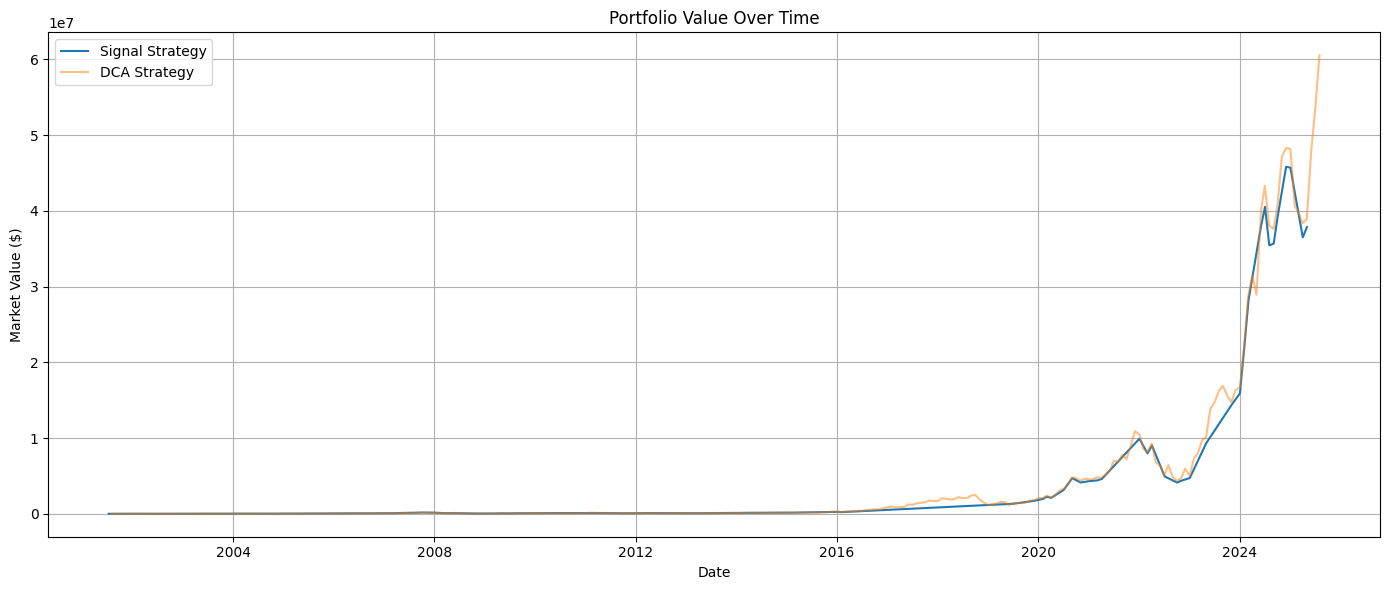

In [5]:
plt.figure(figsize=(14,6))
plt.plot(signal_portfolio.index, signal_portfolio["Market Value"], label="Signal Strategy")
plt.plot(dca_portfolio.index, dca_portfolio["Market Value"], label="DCA Strategy",alpha=0.5)
plt.title("Portfolio Value Over Time")
plt.ylabel("Market Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


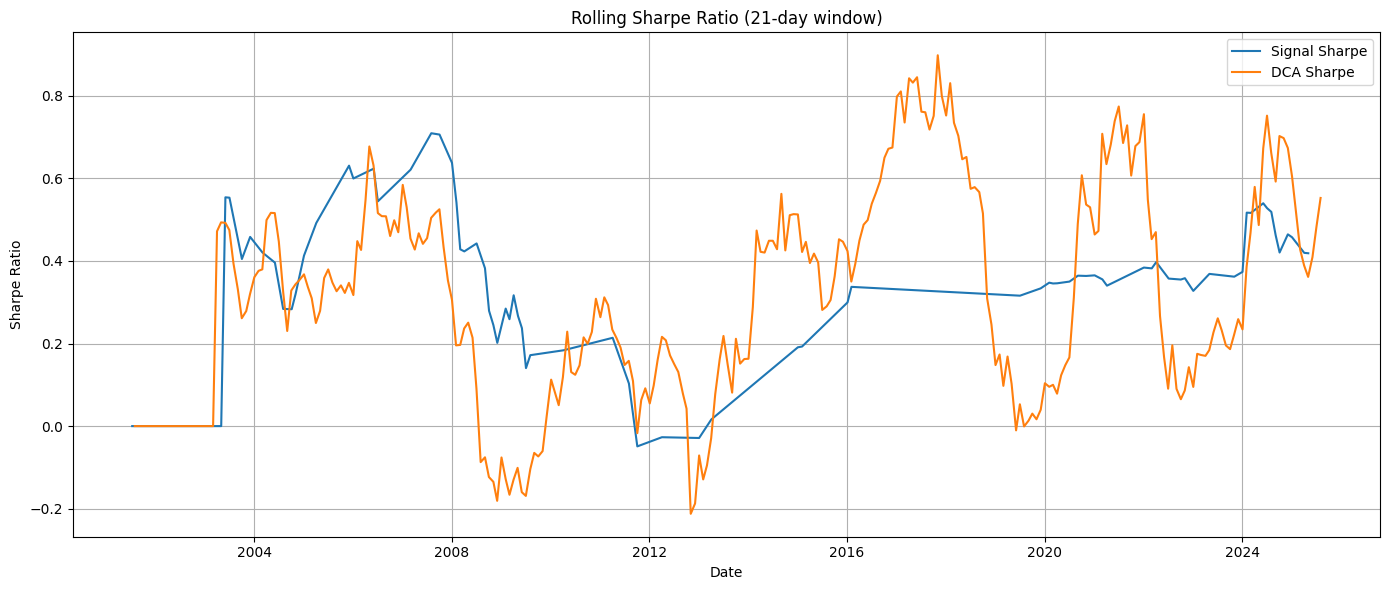

In [ ]:
# Daily returns
signal_returns = signal_portfolio["Market Value"].pct_change().fillna(0)
dca_returns = dca_portfolio["Market Value"].pct_change().fillna(0)

# Rolling Sharpe (monthly window ~21 trading days)
roll_window = 21
risk_free_rate = 0

rolling_sharpe_signal = (signal_returns.rolling(roll_window).mean() /
                         signal_returns.rolling(roll_window).std()).fillna(0)

rolling_sharpe_dca = (dca_returns.rolling(roll_window).mean() /
                      dca_returns.rolling(roll_window).std()).fillna(0)

plt.figure(figsize=(14,6))
plt.plot(signal_portfolio.index, rolling_sharpe_signal, label="Signal Sharpe")
plt.plot(dca_portfolio.index, rolling_sharpe_dca, label="DCA Sharpe")
plt.title(f"Rolling Sharpe Ratio ({roll_window}-day window)")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Essentially, the signal is not great. We are exposed to most of the risk while not being rewarded by alot of the gains. This is likely due to NVDAs rise being related to the company specifically as opposed to the sector as a whole (the sector is doing well, nvda is just outpacing it tremendously).